In [2]:
import os
from pathlib import Path
path = Path(os.getcwd())
os.chdir(path.parent.absolute())

import warnings
warnings.filterwarnings('ignore')

import asyncio
import itertools
from datetime import datetime
from IPython import display
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import datetime
import vectorbt as vbt
import plotly.graph_objects as go
import mt4_hst
%matplotlib inline

In [3]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D" # Daily

# Predefine vectorbt Portfolio settings
vbt.settings.portfolio["init_cash"] = 1e4
vbt.settings.portfolio["fees"] = 0.0015 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0015 # 0.25%
vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

Portfolio Settings [Initial]


,Value
Option,
call_seq,default
init_cash,10000.0
size,100
size_type,amount
fees,0.0015
fixed_fees,0.0
slippage,0.0015
reject_prob,0.0
min_size,0.0


In [16]:
# Example Long Trends for the selected Asset
# * Uncomment others for exploration or replace them with your own TA Trend Strategy
def trends(df: pd.DataFrame):
    # create neccesary indicators
    df.ta.sma(50, append=True)
    df.ta.ema(10, append=True)
    df.ta.ema(20, append=True)
    donchian_20 = ta.donchian(df['high'], df['low'], lower_length=20, upper_length=20)
    donchian_50 = ta.donchian(df['high'], df['low'], lower_length=50, upper_length=50)
    df['DCL_20_20'] = donchian_20['DCL_20_20']
    df['DCL_50_50'] = donchian_50['DCL_50_50']
    
    # condition
    df['close>sma50'] = (df['close'] > df['SMA_50']).astype(int)
    df['ema10>ema20'] = (df['EMA_10'] > df['EMA_20']).astype(int)
    df['higher_low'] = (df['DCL_20_20'] > df['DCL_50_50']).astype(int)
    return (df['close>sma50'] & df['ema10>ema20'] & df['higher_low'])
    # return ta.ma(mamode, df.close, length=fast) > ta.ma(mamode, df.close, length=slow) # SMA(fast) > SMA(slow) "Golden/Death Cross"
#     return ta.increasing(ta.ma(mamode, df.close, length=fast)) # Increasing MA(fast)
#     return ta.macd(df.close, fast, slow).iloc[:,1] > 0 # MACD Histogram is positive

In [25]:
df = mt4_hst.read_hst("stock_env/datasets/FPT1440.hst")
df = df[df['time'] >= '2018-01-01']
df.index = df['time']
df.ta.tsignals(trends(df), asbool=True, append=True)
df.ta.cdl_pattern(name=["closingmarubozu", "marubozu", "engulfing", "longline"], append=True)
df.tail()
# df.to_csv('temp/df_signals.csv', index=False)

,time,open,high,low,close,volume,SMA_50,EMA_10,EMA_20,DCL_20_20,...,ema10>ema20,higher_low,TS_Trends,TS_Trades,TS_Entries,TS_Exits,CDL_CLOSINGMARUBOZU,CDL_MARUBOZU,CDL_ENGULFING,CDL_LONGLINE
time,,,,,,,,,,,,,,,,,,,,,
2022-07-19,2022-07-19,82.900002,83.000000,82.199997,83.000000,1185400.0,86.556227,83.505280,84.828670,82.199997,...,0,1,False,0,False,False,0.0,0.0,0.0,0.0
2022-07-20,2022-07-20,85.000000,85.900002,84.000000,84.900002,2848900.0,86.571333,83.758866,84.835463,82.199997,...,0,1,False,0,False,False,0.0,0.0,0.0,0.0
2022-07-21,2022-07-21,85.900002,85.900002,84.500000,85.000000,1804200.0,86.692484,83.984527,84.851133,82.199997,...,0,1,False,0,False,False,0.0,0.0,0.0,0.0
2022-07-22,2022-07-22,86.400002,86.500000,85.099998,85.099998,1307200.0,86.848666,84.187340,84.874835,82.199997,...,0,1,False,0,False,False,-100.0,-100.0,0.0,-100.0
2022-07-25,2022-07-25,87.000000,87.000000,85.099998,85.400002,2245900.0,87.017454,84.407824,84.924851,82.199997,...,0,1,False,0,False,False,0.0,0.0,0.0,-100.0


In [31]:
cdl_pattern_cols = 'CDL_CLOSINGMARUBOZU CDL_MARUBOZU CDL_ENGULFING CDL_LONGLINE'.split()
cdl_pattern = df[cdl_pattern_cols]
cdl_pattern[cdl_pattern.any(1) != 0].tail(20)

,CDL_CLOSINGMARUBOZU,CDL_MARUBOZU,CDL_ENGULFING,CDL_LONGLINE
time,,,,
2022-05-16,-100.0,-100.0,0.0,-100.0
2022-05-17,100.0,0.0,100.0,100.0
2022-05-25,100.0,0.0,0.0,0.0
2022-05-27,100.0,100.0,0.0,100.0
2022-06-03,100.0,0.0,0.0,100.0
2022-06-07,100.0,0.0,100.0,0.0
2022-06-10,-100.0,0.0,0.0,0.0
2022-06-13,-100.0,0.0,0.0,0.0
2022-06-14,0.0,0.0,100.0,100.0


# Backtest

In [6]:
# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    df.close,
    entries=df.TS_Entries,
    exits=df.TS_Exits,
)

In [8]:
fig = df.close.vbt.plot(trace_kwargs=dict(name='Close'))
assetpf_signals.positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)

FigureWidget({
    'data': [{'name': 'Close',
              'showlegend': True,
              'type': 'scatter…


    Annual return     :  5.01%
    Cumulative return :  24.68%
    Sharpe ratio      :  0.57
    Maximum Drawdown  : -17.74%
    Annual Volatility :  9.28%
    Value-At-Risk     :  nan%
    


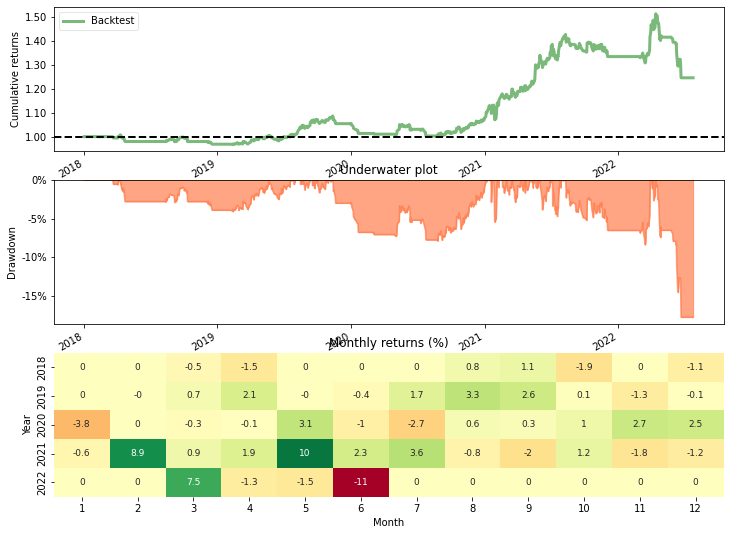

In [14]:
from stock_env.utils import create_performance
values = assetpf_signals.value()
values.index = df['time']
returns = values.pct_change()
create_performance(returns)

In [15]:
values.vbt.drawdowns.plot()

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'showlegend': False,
              't…